## Setup Project
Import used packages


In [1]:
# import required libraries
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import glob
import warnings
from sklearn import mixture
import itertools
import seaborn as sns

Setup global plot settings

In [2]:

# configure notebook for plotting
%pylab inline --no-import-all 
mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color'] # allows access to colours
# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(20,20)  
matplotlib.rcParams['font.size']=16    
matplotlib.rcParams['savefig.dpi']= 300   
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


## Data entry and categorisation
Enter data file location and initiate variables

In [3]:

# import data from Data directory
allPointsFiles = glob.glob('../Data/*/*/points.txt')
allFuzzyFiles = glob.glob('../Data/*/*/fuzzy.txt')
allVaryingPointFiles = glob.glob('../Data/*/*/P*.csv')
allXrayFiles = glob.glob('../Data/XrayFlash.txt')
farPoints = []
midPoints = []
closePoints = []
variablePoints = []
xRayPoints = []
totalPoints = 0


### Categorise and process Points
Iterate through points files and categorize points into close and far points, where close points can be measured by parallax accurately.\
Convert to useful data types in process.\
points data format: [Name, x, y, parsec, HRx, Absolute magnitude, Apparent magnitude, Radial Velocity]

In [4]:
for j, pointsFile in enumerate(allPointsFiles):
    try:
        this = Table.read(pointsFile,format='ascii')
        totalPoints= totalPoints+len(this)
        thispar = this['par']
        thism0, thism1, thism2 = (np.log10(this['flux1']), 
                                  np.log10(this['flux2']), 
                                  np.log10(this['flux3']))
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist)
        
        # transform coords onto "sky net" based on file path and store in numpy array          
        if pointsFile.rfind('Up')!=-1:
            points = np.array([this['name'], this['y'], -this['x']+90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Front')!=-1:
            points = np.array([this['name'], this['y']-90, -this['x']+90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Right')!=-1:
            points = np.array([this['name'], this['x'], this['y'], thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Back')!=-1:
            points = np.array([this['name'], this['x']+90, this['y'], thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Left')!=-1:
            points = np.array([this['name'], this['y']-90, -this['x']+180, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Down')!=-1:
            points = np.array([this['name'], this['y'], -this['x']-90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
            
        # sort into close and far
        for point in points:
            if float(point[3]) > 0.006:
                closePoints.append(point)
            elif float(point[3]) < 0.0042:# value chosen to minimize clusters being assigned to mid distance
                farPoints.append(point)   
            else:
                midPoints.append(point)  
    except:
        pass
closePointsNumpy=np.array(closePoints)
midPointsNumpy=np.array(midPoints)
farPointsNumpy=np.array(farPoints)

### Categorise Fuzzies
A similar process as used on the points data

### Categorise Xray flashes


In [5]:
for j, XrayFiles in enumerate(allXrayFiles):
    try:
        this = Table.read(XrayFiles,format='ascii')
        for line in this:
            # transform coords onto "sky net" based on file path and store in numpy array          
            if line['Camera']==('Up'):
                Xrays = np.array([line['y'], -line['x']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Front'):
                Xrays = np.array([ line['y']-90, -line['x']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Right'):
                Xrays = np.array([ line['x'], line['y'], line['mag']]).T.tolist()
            elif line['Camera']==('Back'):
                Xrays = np.array([line['x']+90, line['y'], line['mag']]).T.tolist()
            elif line['Camera']==('Left'):
                Xrays = np.array([ line['y']-90, -line['x']+180, line['mag']]).T.tolist()
            elif line['Camera']==('Down'):
                Xrays = np.array([ line['y'], -line['x']-90, line['mag']]).T.tolist()

            xRayPoints.append(Xrays)
    except:
        pass
xRayPointsNumpy=np.array(xRayPoints)

## Check IO
A star map to check all are present, a benchmark HR diagram and a cluster map.

### HR Data plot

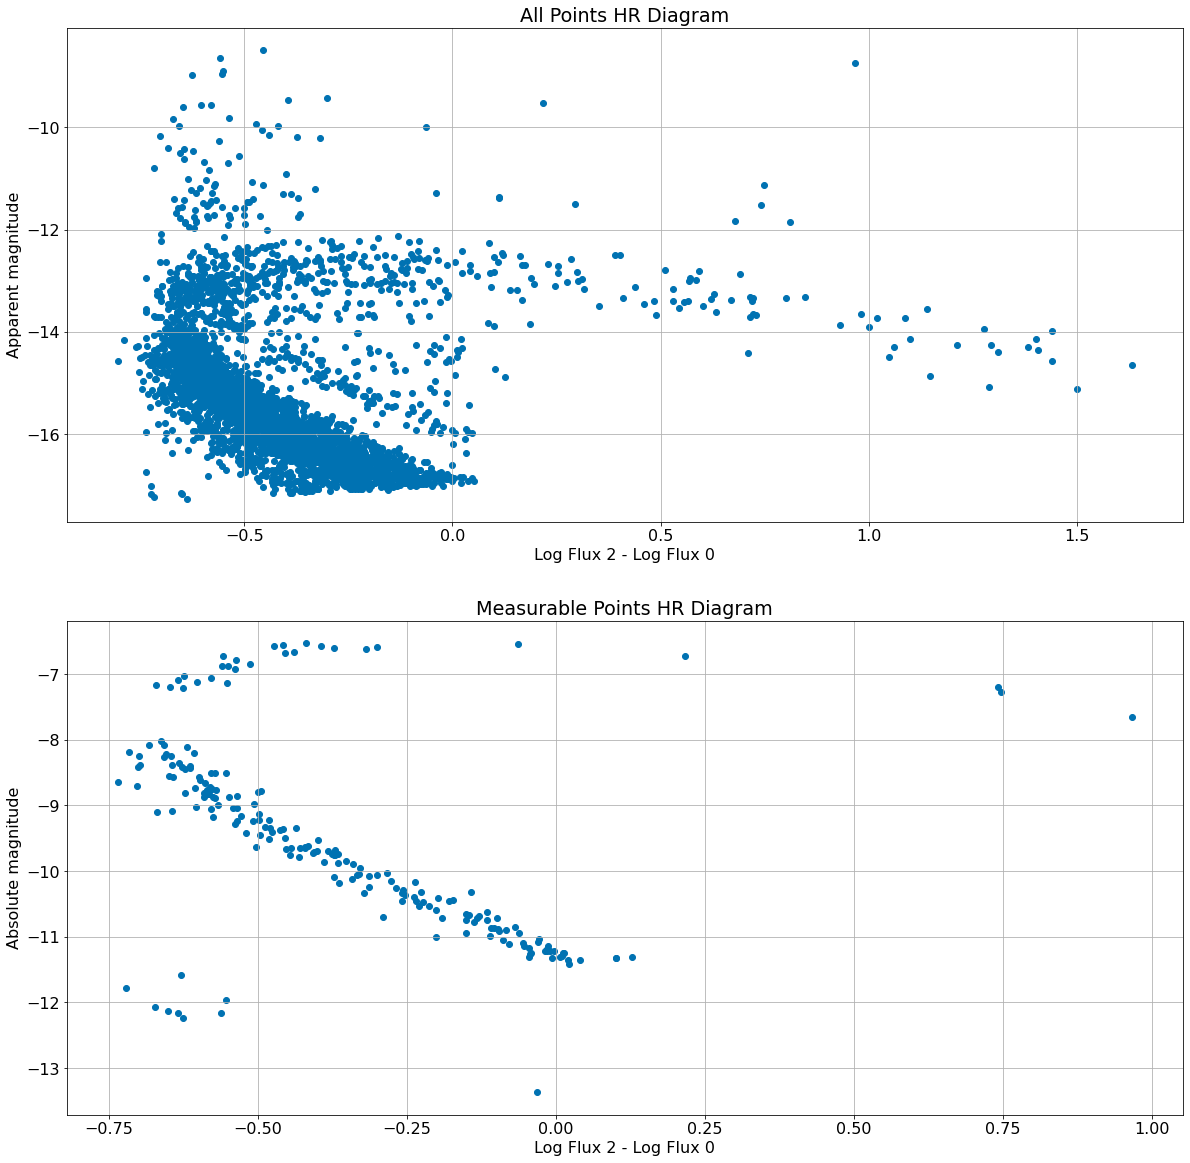

In [6]:
figApparentHR = plt.figure()
ax1 = figApparentHR.add_subplot(2, 1, 1)
allPoints_HRfloats=(np.concatenate((closePointsNumpy[:,[4,6]],midPointsNumpy[:,[4,6]],farPointsNumpy[:,[4,6]]))).astype(np.float)
# figure for HR diagram Template
plt.ylabel('Apparent magnitude')
plt.xlabel('Log Flux 2 - Log Flux 0')
plt.title('All Points HR Diagram')
plt.scatter((allPoints_HRfloats.T)[0].astype(np.float),(allPoints_HRfloats.T)[1].astype(np.float))
plt.grid()

ax2 = figApparentHR.add_subplot(2, 1, 2)
# MeasurablePoints_HRfloats=(np.concatenate((closePointsNumpy[:,[4,5]],midPointsNumpy[:,[4,5]]))).astype(np.float)
# figure for HR diagram Template
plt.ylabel('Absolute magnitude')
plt.xlabel('Log Flux 2 - Log Flux 0')
plt.title('Measurable Points HR Diagram')
# plt.scatter((MeasurablePoints_HRfloats.T)[0].astype(np.float),(MeasurablePoints_HRfloats.T)[1].astype(np.float))
plt.scatter((closePointsNumpy[:,4]).astype(np.float),(closePointsNumpy[:,5]).astype(np.float))
# plt.scatter((midPointsNumpy[:,4]).astype(np.float),(midPointsNumpy[:,5]).astype(np.float))
plt.grid()


### Unfolded sky map plot

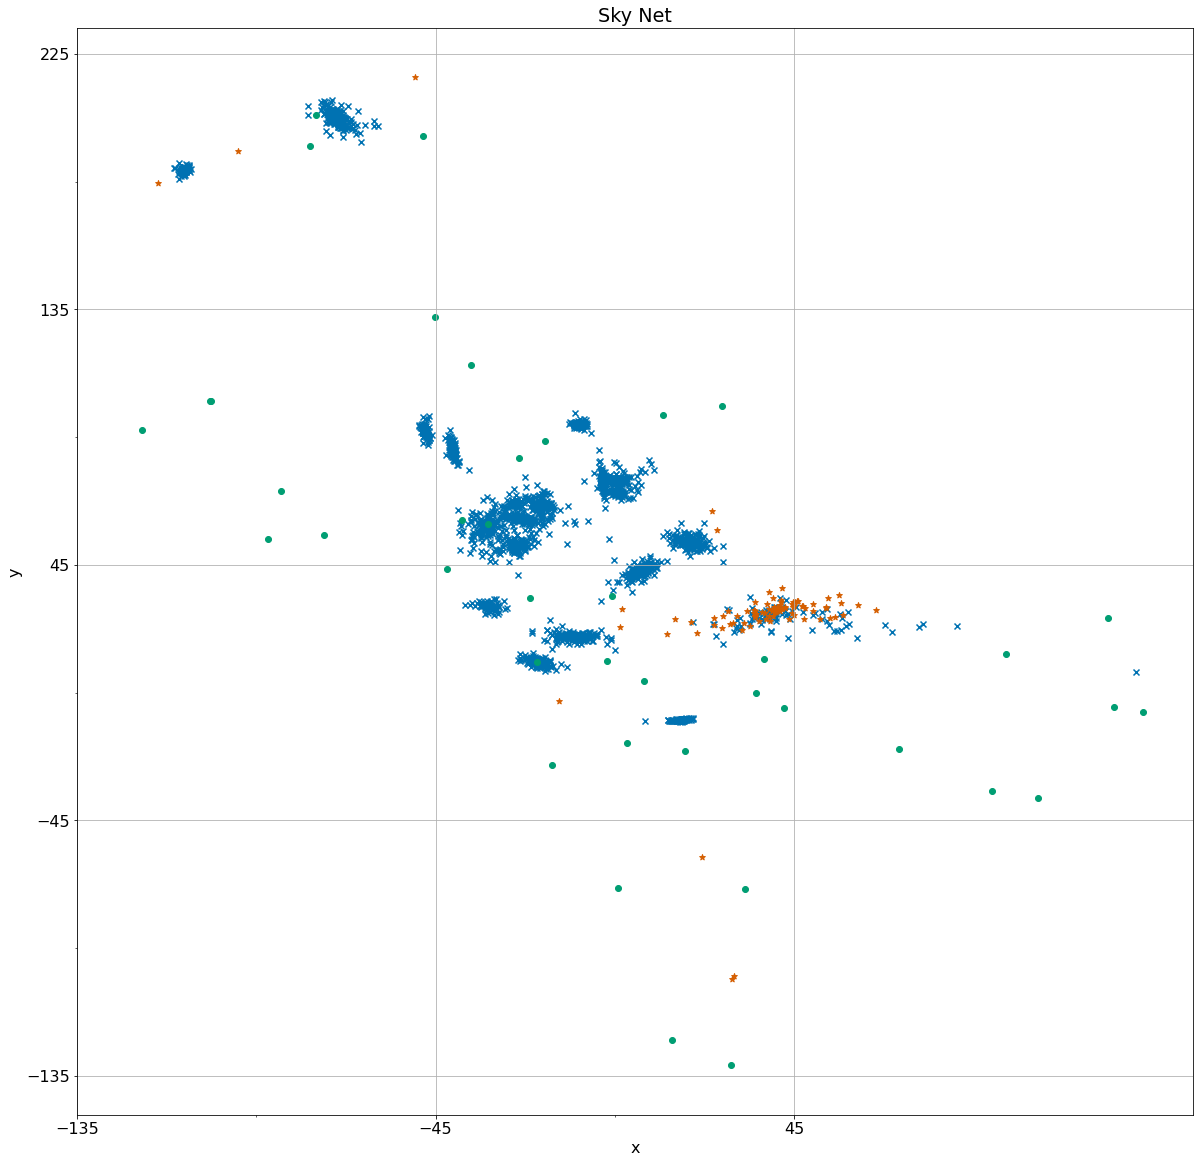

In [7]:
# figure for HR diagram benchmark
skyNet= plt.figure()
ax = skyNet.add_subplot(1, 1, 1)
plt.ylabel('y')
plt.xlabel('x')
plt.title('Sky Net')

plt.scatter((farPointsNumpy.T)[1].astype(np.float),(farPointsNumpy.T)[2].astype(np.float), marker = 'x')
plt.scatter((xRayPointsNumpy.T)[0].astype(np.float),(xRayPointsNumpy.T)[1].astype(np.float), marker = 'o')
plt.scatter((midPointsNumpy.T)[1].astype(np.float),(midPointsNumpy.T)[2].astype(np.float), marker = '*')

yticksMajor = [-135,-45,45,135,225]
yticksMinor = [-90,0,90,180]
xticksMajor = [-135,-45,45]
xticksMinor = [-90,0]

ax.set_xticks(xticksMajor)
ax.set_yticks(yticksMajor)
ax.set_xticks(xticksMinor, minor=True)
ax.set_yticks(yticksMinor, minor=True)
plt.grid()

### Dummy Training Data
- generate gaussian cluster in skymap at upper boundary of Paralax with HR diagram generated from paralaxable data points.

## Cluster processing

Process:
- Use x, y, HRx and HRy in a Bayesian Gaussian mixture model (BGMM) clustering with parallaxable points serving as an informative prior for the BGMM.

    - If any of the sky map clusters don't have a max density (or close too) at the mean xy position, increase weight_concentration_prior and iterate.
    - check fit of cluster onto regressed gaussian in sky map, if fit is below threshold, increase 

In [8]:
# BGMM parameters
clusterCount = 1   #initial clusterCount
countStep = 20
CountTrials = 2
WCP = 10            #weight_concentration_prior
MPR = 10            #mean_precision_prior
# Data for BGMM pror
clusterPrior = closePointsNumpy[:,[1,2,4,5]].astype(np.float)
# Data for BGMM
farPoints_floats = farPointsNumpy[:,[1,2,4,6]].astype(np.float)


# loop with BGMM cluster algorithm and check when some weights go to 0.
clustersModel = (mixture.BayesianGaussianMixture(n_components=clusterCount,weight_concentration_prior=WCP, weight_concentration_prior_type = 'dirichlet_distribution',  mean_precision_prior=MPR, covariance_type="full",n_init = CountTrials)).fit(farPoints_floats[:,[0,1]])
while min(clustersModel.weights_)>(0.001/clusterCount):
    clusterCount=clusterCount+countStep
    clustersModel = (mixture.BayesianGaussianMixture(n_components=clusterCount,weight_concentration_prior=WCP, weight_concentration_prior_type = 'dirichlet_distribution', mean_precision_prior=MPR, covariance_type="full",n_init = CountTrials)).fit(farPoints_floats[:,[0,1]])
clusterShapes = clustersModel.fit_predict(farPoints_floats[:,[0,1]])

In [9]:
# BGMM parameters
# clusterCount = 1   #initial clusterCount
# countStep = 20
# CountTrials = 2
# WCP = 1            #weight_concentration_prior
# MPR = 1            #mean_precision_prior
# # Data for BGMM pror
# clusterPrior=closePointsNumpy[:,[1,2,4,5]].astype(np.float)
# # Data for BGMM
# farPoints_floats=farPointsNumpy[:,[1,2,4,6]].astype(np.float)


# # loop with BGMM cluster algorithm and check when some weights go to 0.
# clustersModel = (mixture.BayesianGaussianMixture(n_components=clusterCount,weight_concentration_prior=WCP, mean_precision_prior=MPR, covariance_type="full",n_init = CountTrials)).fit(farPoints_floats)
# while min(clustersModel.weights_)>(0.01/clusterCount):
#     clusterCount=clusterCount+countStep
#     clustersModel = (mixture.BayesianGaussianMixture(n_components=clusterCount,weight_concentration_prior=WCP, mean_precision_prior=MPR, covariance_type="full",n_init = CountTrials)).fit(farPoints_floats)
# clusterShapes = clustersModel.fit_predict(farPoints_floats)

### Plot Skymap and HR diagram Clustering

### Individual Cluster Plots

<Figure size 864x288 with 0 Axes>

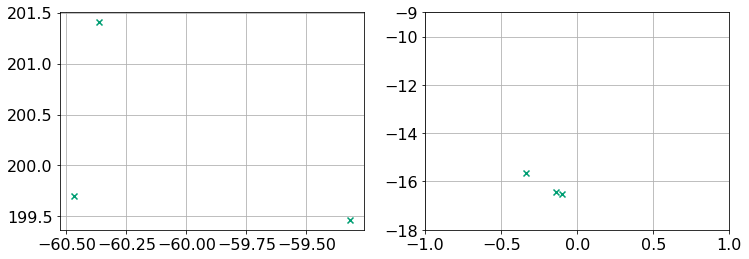

<Figure size 864x288 with 0 Axes>

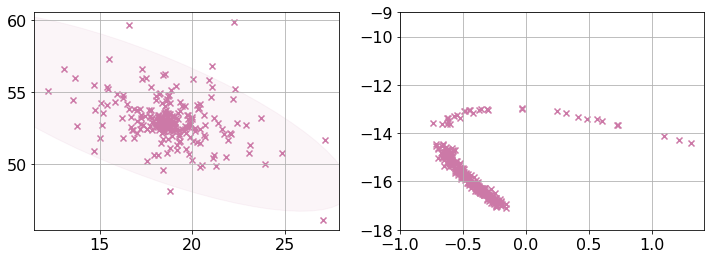

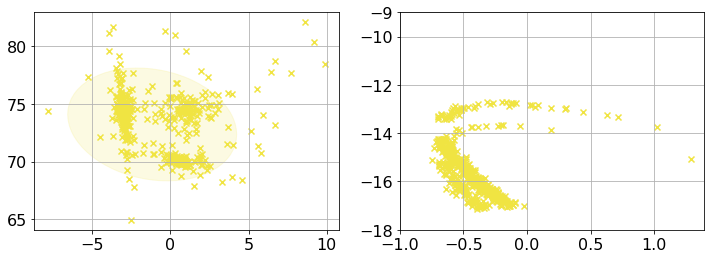

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

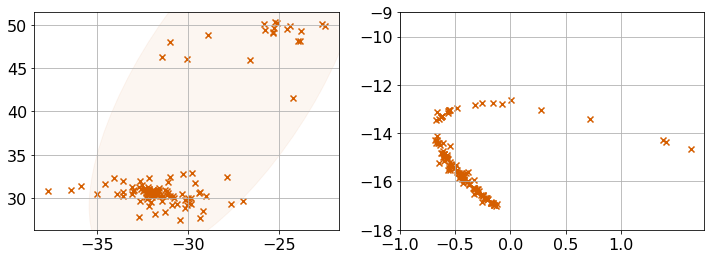

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

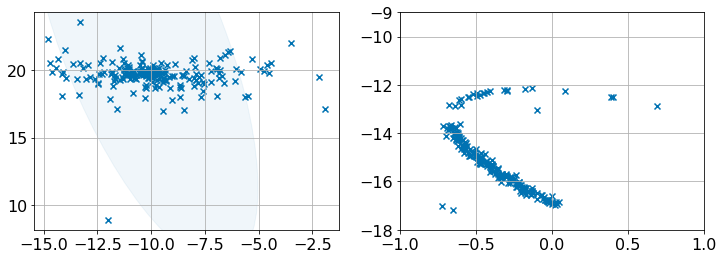

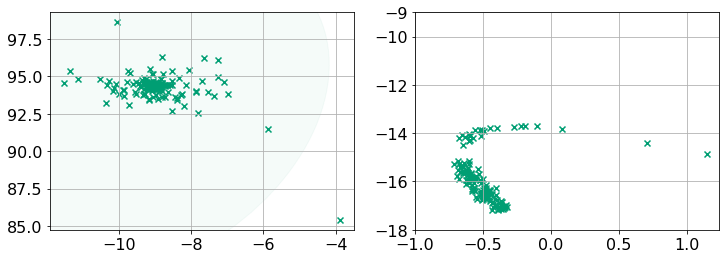

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

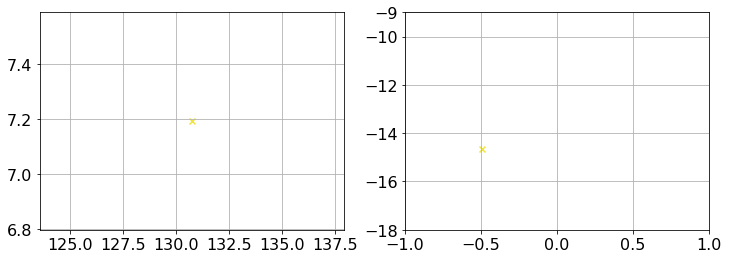

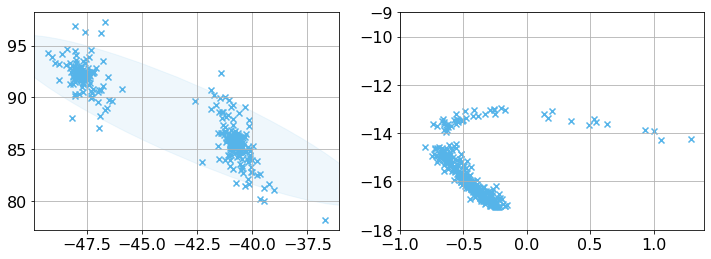

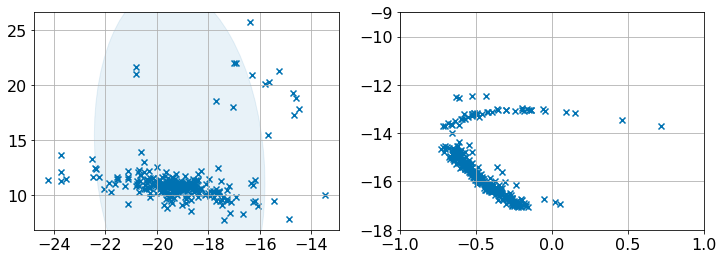

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

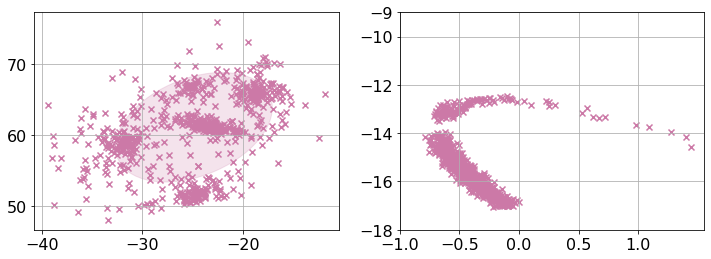

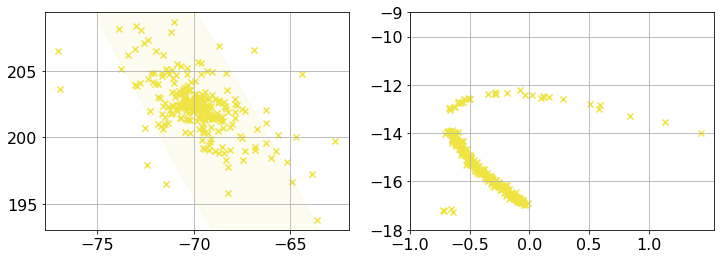

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

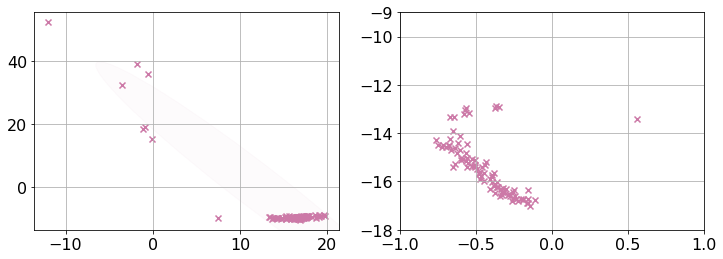

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

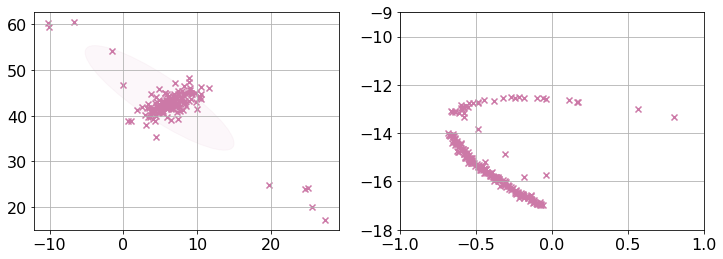

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

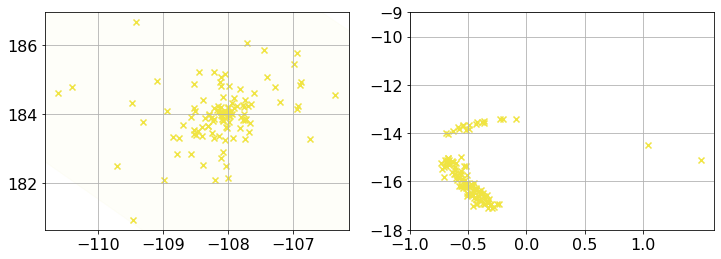

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

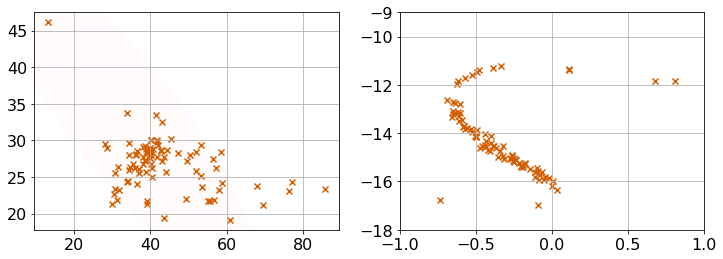

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

In [10]:
matplotlib.rcParams['figure.figsize']=(12,4)  
colorCycle = itertools.cycle(sns.color_palette())
clusterPlots=[]
for i, (mean, cov, color, weights) in enumerate(zip(clustersModel.means_, clustersModel.covariances_, colorCycle, clustersModel.weights_)):
    clusterPlots.append(mpl.pyplot.figure())
    
    v, w = sp.linalg.eigh(cov)
    if not np.any(clusterShapes == i) or weights<(0.0/clusterCount):
        continue
    ### Sky map cluster plot
    ax1 = clusterPlots[i].add_subplot(1, 2, 1)
    plt.grid()
    plt.scatter(farPoints_floats[clusterShapes == i, 0], farPoints_floats[clusterShapes == i, 1], color= color, marker ='x')
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(ax1.bbox)
    ell.set_alpha(weights)
    ax1.add_artist(ell)
    
    
    ### HR diagram cluster plot
    ax2 = clusterPlots[i].add_subplot(1, 2, 2)
    plt.grid()
    mpl.pyplot.scatter(farPoints_floats[clusterShapes == i, 2], farPoints_floats[clusterShapes == i, 3], marker = 'x', color=color)
    # Plot an ellipse to show the Gaussian component
    # angle = np.arctan2(w[2][1], w[2][0])
    # angle = 180.0 * angle / np.pi  # convert to degrees
    # v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    # ell2 = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    # ell2.set_clip_box(ax2.bbox)
    # ell2.set_alpha(weights)
    # ax2.add_artist(ell2)
    
    yticksMajor = [-18,-16,-14,-12,-10,-9]
    xticksMajor = [-1,-0.5,0,0.5,1]

    ax2.set_xticks(xticksMajor)
    ax2.set_yticks(yticksMajor)

plt.show()   

In [11]:
# # Plot the Skymap Contours
# ClusterFitSkyPlot= mpl.pyplot.figure()
# ax = ClusterFitSkyPlot.add_subplot(1, 1, 1)
# HRFitPlot= mpl.pyplot.figure()
# HRax = HRFitPlot.add_subplot(1, 1, 1)
# colorCycle = itertools.cycle(sns.color_palette())
# for i, (mean, cov, color, weights) in enumerate(zip(clustersModel.means_, clustersModel.covariances_, colorCycle, clustersModel.weights_)):
#     v, w = sp.linalg.eigh(cov)
#     if not np.any(clusterShapes == i) or weights<(0.01/clusterCount):
#         continue
#     mpl.pyplot.figure(ClusterFitSkyPlot)
#     mpl.pyplot.sca(ax)
#     plt.scatter(farPoints_floats[clusterShapes == i, 0], farPoints_floats[clusterShapes == i, 1], color= color, marker ='x')
#     angle = np.arctan2(w[0][1], w[0][0])
#     angle = 180.0 * angle / np.pi
#     v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
#     ell.set_clip_box(ax.bbox)
#     ell.set_alpha(weights)
#     ax.add_artist(ell)
    
#     mpl.pyplot.figure(HRFitPlot)
#     mpl.pyplot.sca(HRax)
#     mpl.pyplot.scatter(farPoints_floats[clusterShapes == i, 2], farPoints_floats[clusterShapes == i, 3], marker = 'x', color=color)
#     # Plot an ellipse to show the Gaussian component
#     angle = np.arctan2(w[2][1], w[2][0])
#     angle = 180.0 * angle / np.pi  # convert to degrees
#     v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
#     ell.set_clip_box(HRax.bbox)
#     ell.set_alpha(weights)
#     HRax.add_artist(ell)
    
# plt.grid()
# mpl.pyplot.figure(ClusterFitSkyPlot)
# mpl.pyplot.sca(ax)
# plt.grid()
# plt.show()   

## Recombine cluster branches

- group xy proximity clusters then compare highest HRy with Lowest HRy points, if they approximately match, merge clusters.